<a href="https://colab.research.google.com/github/reitezuz/18NES1-2026/blob/main/week02/compare_perceptron_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparison of the variants of the Perceptron training algorithm on a binary classification task using randomly generated data
1. iterative algorithm
2. batch algorithm
3. hebbian algorithm
3. variant with low / high learning rate
4. variant that stores the best solution

In [1]:
# load the perceptron_library.py file into google colab
import urllib.request

url = 'https://raw.githubusercontent.com/reitezuz/18NES1-2026/refs/heads/main/week02/perceptron_library.py'
filename = 'perceptron_library.py'
urllib.request.urlretrieve(url, filename)


('perceptron_library.py', <http.client.HTTPMessage at 0x7cc8d322c5c0>)

In [2]:
# import libraries
from perceptron_library import Perceptron, perceptron_error, plot_decision_boundary_2D, plot_decision_boundary_3D
import numpy as np
import time
import pandas as pd

## Auxiliary functions
The following cell defines functions for running perceptron learning experiments:
- functions that create the training data, e.g. `example_random` or `example_random_clusters`
- `run_example` function performs the perceptron learning process
- `run_example_multiple_times` function performs the perceptron learning process multiple times and averages the results

In [3]:
def example_random():
    # Generate random data
    #np.random.seed(42)  # For reproducibility
    noise_ratio = 0.1
    N = 40
    inputs = np.random.uniform(-1, 1, (N, 2))  # 20 samples, 2 features
    true_outputs = np.where(inputs[:, 0] + inputs[:, 1] > 0, 1, -1)  # Simple linear decision boundary

    # Introduce noise by flipping some labels
    num_noisy = int(noise_ratio * N)
    noisy_indices = np.random.choice(N, num_noisy, replace=False)
    true_outputs[noisy_indices] *= -1

    return inputs, true_outputs


def example_random_clusters():
    """ Generate two separable clusters """
    N=40
    spread=2.0
    #np.random.seed(42)  # For reproducibility
    cluster_1 = np.random.randn(N//2, 2) * spread + np.array([2, 2])
    cluster_2 = np.random.randn(N//2, 2) * spread + np.array([-2, -2])
    inputs = np.vstack((cluster_1, cluster_2))
    true_outputs = np.hstack((np.ones(N//2), -np.ones(N//2)))  # Labels for clusters
    return inputs, true_outputs



def run_example(experiment_results, inputs, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description):

    # Train the perceptron:
    start_time = time.time()
    perceptron = Perceptron(weights, bias, binary)
    if variant == 'rosenblatt best':
        perceptron.rosenblatt_iterative_best(inputs, true_outputs, learning_rate, epochs, print_progress)
    elif variant == 'rosenblatt iterative':
        perceptron.rosenblatt_iterative(inputs, true_outputs, learning_rate, epochs, print_progress)
    elif variant == 'rosenblatt batch':
        perceptron.rosenblatt_batch(inputs, true_outputs, learning_rate, epochs, print_progress)
    else:
        perceptron.hebbian(inputs, true_outputs, print_progress)
    end_time = time.time()  # Record end time
    elapsed_time = end_time - start_time

    # Print summary:
    print(perceptron)
    real_outputs = perceptron.forward(inputs) # forward for the whole dataset
    error = perceptron_error(true_outputs, real_outputs)
    print(f"Perceptron error: {error}")
    if len(weights) == 2 and print_progress:
        plot_decision_boundary_2D(perceptron, inputs, true_outputs)
    elif len(weights) == 3 and print_progress:
        plot_decision_boundary_3D(perceptron, inputs, true_outputs)

    # Print table with real and predicted outputs for all the data:
    df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
    for inputs, label in zip(inputs, true_outputs):
        df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

    # Create a dictionary to store the results
    results = {
        'Epochs': perceptron.epochs,
        'Error': error,
        'Time': elapsed_time,
        'Variant': variant,
        'Learning Rate': learning_rate,
        'Max Epochs': epochs,
        'Weights': perceptron.weights,
        'Bias': perceptron.bias,
        'Data Description': data_description
        # Add other parameters as needed
    }

    # Append the results to the DataFrame
    experiment_results.loc[len(experiment_results)] = results
    df

def run_example_multiple_times(experiment_results, inputs, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description, num_runs=100):
    times = []
    errors = []
    epoch_counts = []

    for _ in range(num_runs):
        perceptron = Perceptron(weights, bias, binary)
        start_time = time.time()
        if variant == 'rosenblatt best':
            perceptron.rosenblatt_iterative_best(inputs, true_outputs, learning_rate, epochs, False)  # Suppress individual run progress
        elif variant == 'rosenblatt iterative':
            perceptron.rosenblatt_iterative(inputs, true_outputs, learning_rate, epochs, False)
        elif variant == 'rosenblatt batch':
            perceptron.rosenblatt_batch(inputs, true_outputs, learning_rate, epochs, False)
        else:
            perceptron.hebbian(inputs, true_outputs, False)
        end_time = time.time()
        elapsed_time = end_time - start_time

        real_outputs = perceptron.forward(inputs)
        error = perceptron_error(true_outputs, real_outputs)

        times.append(elapsed_time)
        errors.append(error)
        epoch_counts.append(perceptron.epochs)

    avg_time = np.mean(times)
    avg_error = np.mean(errors)
    avg_epochs = np.mean(epoch_counts)

    results = {
        'Epochs': avg_epochs,
        'Error': avg_error,
        'Time': avg_time,
        'Variant': variant,
        'Learning Rate': learning_rate,
        'Max Epochs': epochs,
        'Weights': perceptron.weights, #Note: Weights and bias are from the last run.
        'Bias': perceptron.bias,
        'Data Description': data_description
    }
    experiment_results.loc[len(experiment_results)] = results

## Example 1:  Randomly Generated Data
- When we compare models, we can start with the (randomly) generated data:

In [4]:
# DataFrame to store the results for comparisons
experiment_results_rand = pd.DataFrame(columns=['Error', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])

- set the parametrers, run the experiment several times and observe the results:
- you can change the training algorithm or other parameters

Rosenblatt iterative:
Epoch: 0, Inputs: [-0.28306854 -0.76826188], Prediction: 0 Old weights: [0. 0.] 0 New weights: [0.28306854 0.76826188] -1
Epoch: 0, Inputs: [0.41371469 0.45801434], Prediction: -1 Old weights: [0.28306854 0.76826188] -1 New weights: [0.69678323 1.22627622] 0
Epoch: 0, Inputs: [-0.86989681  0.89777107], Prediction: 1 Old weights: [0.69678323 1.22627622] 0 New weights: [1.56668004 0.32850514] -1
Epoch: 0, Inputs: [0.20223002 0.41614516], Prediction: -1 Old weights: [1.56668004 0.32850514] -1 New weights: [1.76891007 0.7446503 ] 0
Epoch: 0, Inputs: [-0.85089871  0.97377387], Prediction: -1 Old weights: [1.76891007 0.7446503 ] 0 New weights: [0.91801136 1.71842417] 1
Epoch: 0, Inputs: [-0.4157107  -0.26727631], Prediction: 1 Old weights: [0.91801136 1.71842417] 1 New weights: [1.33372206 1.98570048] 0
Epoch: 0, Inputs: [0.46398788 0.19731697], Prediction: 1 Old weights: [1.33372206 1.98570048] 0 New weights: [0.86973417 1.78838352] -1
Epoch: 0, Inputs: [0.19579996 0.8

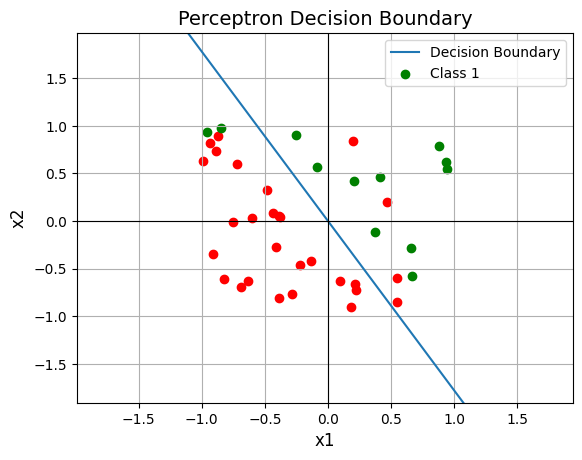


Experiment Results:


,Error,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,6,10,0.051931,rosenblatt iterative,1,10,"[2.704301728645769, 1.5192741431596746]",0,Random


In [5]:
# get the data:
np.random.seed(42)  # For reproducibility
inputs, true_outputs = example_random()
data_description = "Random"

# Set Perceptron parameters:
weights = [0, 0]
bias = 0
binary = False
epochs = 10
learning_rate = 1
print_progress = True
variant = 'rosenblatt iterative' # 'rosenblatt best','rosenblatt iterative', 'rosenblatt batch', 'hebbian'

# run the experiment:
run_example(experiment_results_rand, inputs, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description)

print("\nExperiment Results:")
experiment_results_rand

- comparison:

In [6]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['Error', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
np.random.seed(42)  # For reproducibility
inputs, true_outputs = example_random()
data_description = "Random"
num_runs = 100

# Perceptron parameters:
weights = [0, 0]
bias = 0
binary = False
epochs = 10
learning_rate = 0.1
print_progress = False
for variant, learning_rate in [('rosenblatt best', 1), ('rosenblatt iterative', 1), ('rosenblatt batch', 1), ('hebbian', 1), ('rosenblatt best', 0.1), ('rosenblatt iterative', 0.1), ('rosenblatt batch', 0.1)]:
    run_example_multiple_times(experiment_results_r, inputs, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description, num_runs=num_runs)

print("\nExperiment Results:")
experiment_results_r


Experiment Results:


,Error,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,3.80,10.0,0.026372,rosenblatt best,1.0,10,"[1.7128627472129594, 1.8159939205107272]",0.000000e+00,Random
1,7.43,10.0,0.028738,rosenblatt iterative,1.0,10,"[2.0884847908032587, 2.30504610393895]",0.000000e+00,Random
2,7.00,10.0,0.000708,rosenblatt batch,1.0,10,"[6.441468499730782, 8.375513318454342]",0.000000e+00,Random
3,9.00,1.0,0.000064,hebbian,1.0,10,"[12.386309990322758, 9.356130550027235]",-1.600000e+01,Random
4,3.73,10.0,0.013850,rosenblatt best,0.1,10,"[0.18719234088919826, 0.14448453965016186]",0.000000e+00,Random
5,7.81,10.0,0.008694,rosenblatt iterative,0.1,10,"[0.18631359074883275, 0.2826985273554302]",1.000000e-01,Random
6,7.00,10.0,0.000340,rosenblatt batch,0.1,10,"[0.6441468499730785, 0.8375513318454338]",-2.775558e-17,Random


## Example 2:  Randomly Generated Clustered Data
- When we compare models, we can start with the (randomly) generated data:

In [7]:
# DataFrame to store the results for comparisons
experiment_results_rand = pd.DataFrame(columns=['Error', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])

- set the parametrers, run the experiment and observe the results
you can change the training algorithm or other parameters

Rosenblatt iterative:
Epoch: 0, Inputs: [-2.92127754  0.11424445], Prediction: 0 Old weights: [0. 0.] 0 New weights: [ 2.92127754 -0.11424445] -1
Epoch: 0, Inputs: [-0.30198715  2.75139604], Prediction: -1 Old weights: [ 2.92127754 -0.11424445] -1 New weights: [2.61929039 2.63715158] 0
Epoch: 0, Inputs: [-1.44983567  0.87542494], Prediction: -1 Old weights: [2.61929039 2.63715158] 0 New weights: [1.16945472 3.51257653] 1
Epoch: 0, Inputs: [-0.37494836  0.71248006], Prediction: 1 Old weights: [1.16945472 3.51257653] 1 New weights: [1.54440308 2.80009647] 0
Epoch: 0, Inputs: [ 0.18395185 -0.8246074 ], Prediction: -1 Old weights: [1.54440308 2.80009647] 0 New weights: [1.72835493 1.97548907] 1
Epoch: 0, Inputs: [ 0.06199904 -0.13743976], Prediction: 1 Old weights: [1.72835493 1.97548907] 1 New weights: [1.66635588 2.11292883] 0
Epoch: 0, Inputs: [ 2.41772719 -1.91934025], Prediction: -1 Old weights: [1.66635588 2.11292883] 0 New weights: [4.08408307 0.19358858] 1
Epoch: 1, Inputs: [-0.656

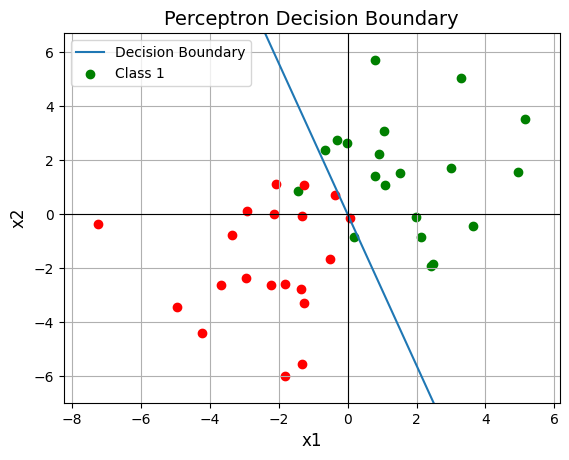


Experiment Results:


,Error,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,3,10,0.040387,rosenblatt iterative,1,10,"[3.7467017878887043, 1.3398330663472424]",0,Random clusters


In [8]:
# get the data:
np.random.seed(42)  # For reproducibility
inputs, true_outputs = example_random_clusters()
data_description = "Random clusters"

# Set Perceptron parameters:
weights = [0, 0]
bias = 0
binary = False
epochs = 10
learning_rate = 1
print_progress = True
variant = 'rosenblatt iterative' # 'rosenblatt best','rosenblatt iterative', 'rosenblatt batch', 'hebbian'

# run the experiment:
run_example(experiment_results_rand, inputs, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description)

print("\nExperiment Results:")
experiment_results_rand

- comparison:

In [9]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['Error', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
np.random.seed(42)  # For reproducibility
inputs, true_outputs = example_random_clusters()
data_description = "Random clusters"

# Perceptron parameters:
weights = [0, 0]
bias = 0
binary = False
epochs = 100
learning_rate = 0.1
print_progress = False
for variant, learning_rate in [('rosenblatt best', 1), ('rosenblatt iterative', 1), ('rosenblatt batch', 1), ('hebbian', 1), ('rosenblatt best', 0.1), ('rosenblatt iterative', 0.1), ('rosenblatt batch', 0.1)]:
    run_example_multiple_times(experiment_results_r, inputs, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description)

print("\nExperiment Results:")
experiment_results_r


Experiment Results:


,Error,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,2.00,100.0,0.113788,rosenblatt best,1.0,100,"[3.1313634504369485, 1.5582349454005533]",0.000000e+00,Random clusters
1,3.73,100.0,0.100254,rosenblatt iterative,1.0,100,"[1.9576520225663152, -0.17289472772200631]",1.000000e+00,Random clusters
2,6.00,100.0,0.003218,rosenblatt batch,1.0,100,"[3.0975856795911216, -0.26336437859971795]",-2.000000e+00,Random clusters
3,3.00,1.0,0.000034,hebbian,1.0,100,"[79.7583637052492, 65.0741664087508]",0.000000e+00,Random clusters
4,2.01,100.0,0.092640,rosenblatt best,0.1,100,"[0.3849897512763383, 0.1537515189567055]",-1.000000e-01,Random clusters
5,3.68,100.0,0.097949,rosenblatt iterative,0.1,100,"[0.47592676508304077, 0.06952029258089076]",2.775558e-17,Random clusters
6,6.00,100.0,0.003459,rosenblatt batch,0.1,100,"[0.3097585679591189, -0.026336437859979966]",-2.000000e-01,Random clusters


## Observations:
- Notice that when the comparison is run repeatedly, the results are different each time. Therefore, for a proper comparison, each experiment should be run, for example, 100 times, and the average results (and their variance) should be compared.
- There is no best algorithm. The optimal choice of the algorithm and its parameters always depends on the data.

## More examples - logical functions

In [10]:
def example_gallblader_attack():
    # Egg Salad, Pork Belly, Medicines -> Gallbladder Attack
    inputs = np.array([
        [+1, -1, -1],
        [+1, -1, +1],
        [-1, +1, -1],
        [-1, +1, +1],
        [+1, +1, -1],
        [+1, +1, +1]
    ])

    true_outputs = np.array([
        +1,
        -1,
        +1,
        -1,
        +1,
        +1
    ])
    return inputs, true_outputs

def example_pub():
    # Pavel, Pepa, Honza -> Go to a pub?
    inputs = np.array([
        [ +1, -1, -1],
        [ +1, -1, +1],
        [ -1, +1, -1],
        [ -1, +1, +1],
        [ +1, +1, -1],
        [ +1, +1, +1],
        [ -1, -1, -1],
        [ -1, -1, +1]
    ])

    true_outputs = np.array([-1, +1, -1, +1, +1, +1, -1, -1])
    return inputs, true_outputs

def example_outliers():
    # data with outliers
    inputs = np.array([
        [-0.5, -0.5],
        [ 0.3, -0.5],
        [ -40,   50], # outlier
        [ -0.5, 0.5],
        [ -0.1, 1.0]
    ])

    true_outputs = np.array([1, 1, -1, -1, 1])
    return inputs, true_outputs

### Example:  Gallbladder Attack
- We predict whether a patient will have a gallbladder attack, depending on whether they ate a salad, pork belly, and whether they took medication.

In [18]:
# Simple example
weights = [0, 0, 0]
bias = 0
binary = False
epochs = 10
learning_rate = 1
print_progress = True
variant = 'rosenblatt batch'

p = Perceptron(weights, bias, binary)
x = p.rosenblatt_batch(inputs, true_outputs, learning_rate, epochs, print_progress)

err = perceptron_error(true_outputs, p.forward(inputs))
print(f"Perceptron error: {err}")


Rosenblatt batch:
Epoch: 0 Weights: [ 2.  2. -4.] Bias: 2 6
Epoch: 1 Weights: [ 2.  2. -4.] Bias: 2 0
The training ended after 2 epochs.
Perceptron error: 0


- code similar to the experiments on randomly generated data:

In [11]:
# DataFrame to store the results for comparisons
import pandas as pd
experiment_results = pd.DataFrame(columns=['Error', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])

Rosenblatt batch:
Epoch: 0 Weights: [ 2.  2. -4.] Bias: 2 6
Epoch: 1 Weights: [ 2.  2. -4.] Bias: 2 0
The training ended after 2 epochs.
Perceptron(weights=[ 2.  2. -4.], bias=2, binary=False)
Perceptron error: 0


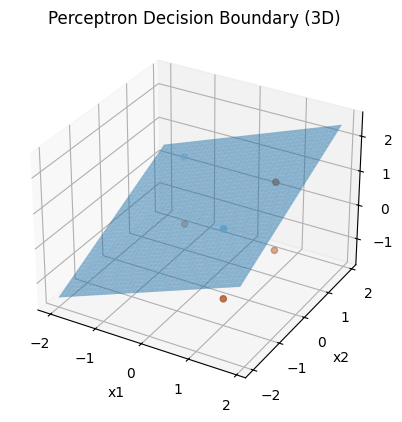


Experiment Results:


,Error,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0,2,0.000714,rosenblatt batch,1,10,"[2.0, 2.0, -4.0]",2,Gallbladder Attack


In [12]:
# Example Gallblader_attack
# get the data:
inputs, true_outputs = example_gallblader_attack()
data_description = "Gallbladder Attack"

# Set Perceptron parameters:
weights = [0, 0, 0]
bias = 0
binary = False
epochs = 10
learning_rate = 1
print_progress = True
variant = 'rosenblatt batch' #'rosenblatt iterative' # 'rosenblatt best','rosenblatt iterative', 'rosenblatt batch', 'hebbian'

# run the experiment:
run_example(experiment_results, inputs, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description)

print("\nExperiment Results:")
experiment_results

- simple comparison:

In [13]:
# Example Gallblader_attack
# DataFrame to store the results for comparisons:
experiment_results_g = pd.DataFrame(columns=['Error', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
inputs, true_outputs = example_gallblader_attack()
data_description = "Gallbladder Attack"

# Perceptron parameters:
weights = [0, 0, 0]
bias = 0
binary = False
epochs = 10
learning_rate = 0.1
print_progress = False
for variant, learning_rate in [('rosenblatt best', 1), ('rosenblatt iterative', 1), ('rosenblatt batch', 1), ('hebbian', 1), ('rosenblatt best', 0.1), ('rosenblatt iterative', 0.1), ('rosenblatt batch', 0.1)]:
    run_example(experiment_results_g, inputs, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description)

print("\nExperiment Results:")
experiment_results_g

Perceptron(weights=[ 2.  2. -2.], bias=0, binary=False)
Perceptron error: 0
Perceptron(weights=[ 3.  3. -3.], bias=1, binary=False)
Perceptron error: 0
Perceptron(weights=[ 2.  2. -4.], bias=2, binary=False)
Perceptron error: 0
Perceptron(weights=[ 2.  2. -4.], bias=2, binary=False)
Perceptron error: 0
Perceptron(weights=[ 0.2  0.2 -0.2], bias=0.2, binary=False)
Perceptron error: 0
Perceptron(weights=[ 0.2  0.2 -0.4], bias=2.7755575615628914e-17, binary=False)
Perceptron error: 0
Perceptron(weights=[ 0.2  0.2 -0.4], bias=0.2, binary=False)
Perceptron error: 0

Experiment Results:


,Error,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0,3,0.002770,rosenblatt best,1.0,10,"[2.0, 2.0, -2.0]",0.000000e+00,Gallbladder Attack
1,0,4,0.001217,rosenblatt iterative,1.0,10,"[3.0, 3.0, -3.0]",1.000000e+00,Gallbladder Attack
2,0,2,0.000223,rosenblatt batch,1.0,10,"[2.0, 2.0, -4.0]",2.000000e+00,Gallbladder Attack
3,0,1,0.000100,hebbian,1.0,10,"[2.0, 2.0, -4.0]",2.000000e+00,Gallbladder Attack
4,0,3,0.000667,rosenblatt best,0.1,10,"[0.2, 0.2, -0.20000000000000004]",2.000000e-01,Gallbladder Attack
5,0,3,0.000548,rosenblatt iterative,0.1,10,"[0.2, 0.20000000000000004, -0.4]",2.775558e-17,Gallbladder Attack
6,0,2,0.000171,rosenblatt batch,0.1,10,"[0.2, 0.2, -0.4]",2.000000e-01,Gallbladder Attack
